## Universal Variance Decomposition
Plots the results of Full Variance Decomposition on best logalpha connectivity models

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.run_model as rm
import matplotlib.pyplot as plt

In [3]:
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
# logalpha_list = [8, 8, 8, 8, 8, 10, 8]
logalpha_list = [6, 6, 4, 4, 2, 8, 6]

# Load the product matrix and metadata vectors 
data = np.load("/home/UWO/ashahb7/Github/bayes_temp/bestSTD_product_matrix.npz", allow_pickle=True)
indices = []
for ds, la in zip(dataset_list, logalpha_list):
    indices.append(np.where((data['dataset_vec'] == ds) & (data['logalpha_vec'] == la))[0])
indices = np.concatenate(indices)
product_la = data['product_matrix'][np.ix_(indices, indices)]
dataset_vec_la = data['dataset_vec'][indices]
sub_vec_la = data['sub_vec'][indices]
part_vec_la = data['part_vec'][indices]

# Solve
full_var_decom_df = rm.decompose_variance_scaled_from_SS(product_la, dataset_vec_la, sub_vec_la, part_vec_la)

Bad pairs (cross-dataset): 10.20%
Bad pairs (cross-subject): 1.99%
Bad pairs (cross-partition): 0.83%
Bad pairs (same-partition): 0.00%


### Raw Full Variance Decomposition

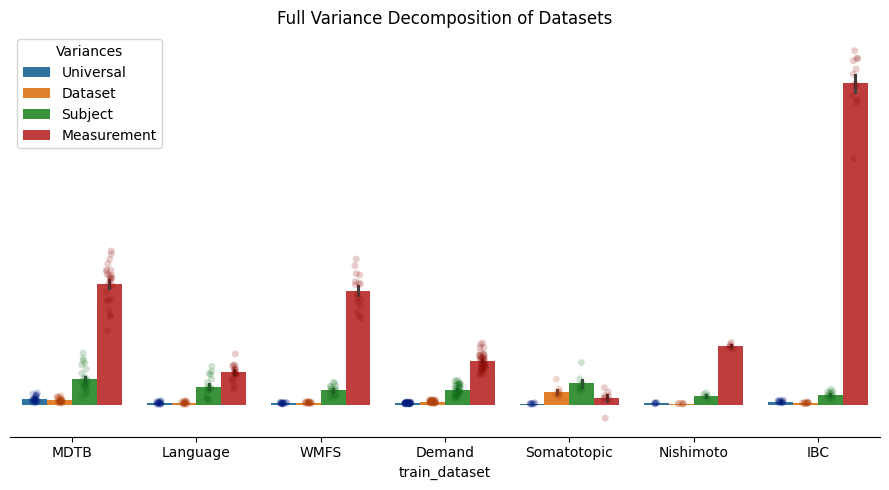

In [4]:
vars = ['v_u', 'v_d', 'v_s', 'v_m']
decom_df = full_var_decom_df.copy()
decom_df['v_m'] /= 2
decom_df[vars] = decom_df[vars].mul(decom_df['sc']**2, axis=0)
df_decom_melt = decom_df.melt(id_vars=['train_dataset'], value_vars=vars, var_name='Variances', value_name='value')

plt.figure(figsize=(9, 5))
ax = sns.barplot(df_decom_melt, x='train_dataset', y='value', hue='Variances', errorbar='se')
sns.stripplot(df_decom_melt, x='train_dataset', y='value', hue='Variances', dodge=True, palette='dark', alpha=0.2, marker='o')

handles, labels = plt.gca().get_legend_handles_labels()
ax.legend(handles=handles, labels=['Universal', 'Dataset', 'Subject', 'Measurement'], title='Variances')
ax.set_yticks([])
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Full Variance Decomposition of Datasets')
plt.tight_layout()

#### Scales are highly correlated with measurement noise

In [5]:
corr_coef = full_var_decom_df.groupby('train_dataset').apply(lambda group: group['v_m'].corr(group['sc']))
print(corr_coef)

train_dataset
Demand        -0.905500
IBC           -0.949926
Language      -0.899123
MDTB          -0.886570
Nishimoto     -0.975961
Somatotopic   -0.910465
WMFS          -0.902401
dtype: float64


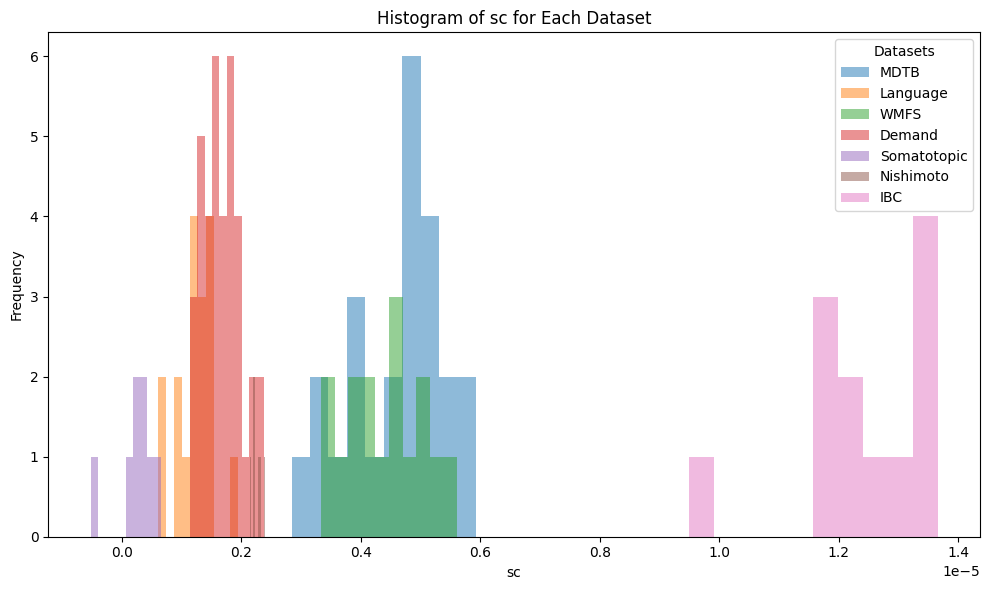

In [6]:
plt.figure(figsize=(10, 6))
for dataset in dataset_list:
    subset = decom_df[decom_df['train_dataset'] == dataset]
    plt.hist(subset['v_m'], bins=10, alpha=0.5, label=dataset)

plt.xlabel('sc')
plt.ylabel('Frequency')
plt.title('Histogram of sc for Each Dataset')
plt.legend(title='Datasets')
plt.tight_layout()
plt.show()

### Undoing the Scales

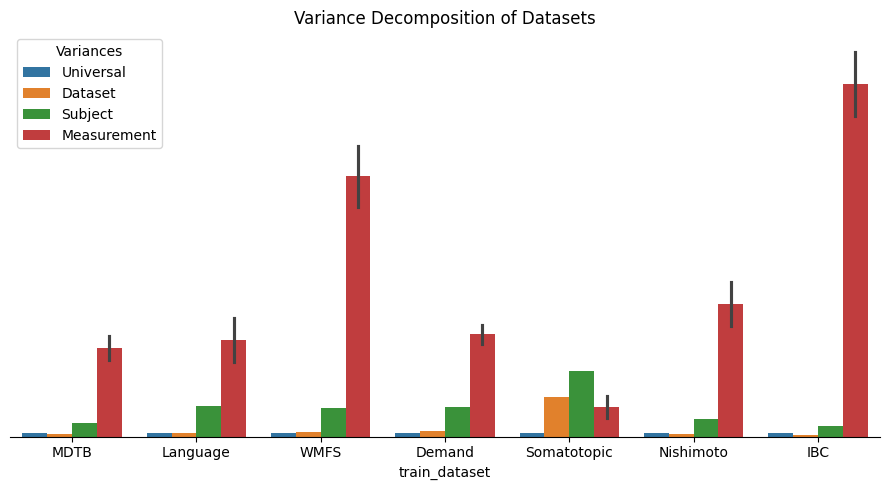

In [7]:
vars = ['v_u', 'v_d', 'v_s', 'v_m']
decom_df = full_var_decom_df[['train_dataset', 'v_u', 'v_d', 'v_s', 'v_m']].copy()
decom_df['v_m'] /= 2
df_decom_melt = decom_df.melt(id_vars=['train_dataset'], value_vars=vars, var_name='Variances', value_name='value')

plt.figure(figsize=(9, 5))
ax = sns.barplot(df_decom_melt, x='train_dataset', y='value', hue='Variances', errorbar='se')

handles, labels = plt.gca().get_legend_handles_labels()
ax.legend(handles=handles, labels=['Universal', 'Dataset', 'Subject', 'Measurement'], title='Variances')
ax.set_yticks([])
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Variance Decomposition of Datasets')
plt.tight_layout()

### Neutralizing Scales

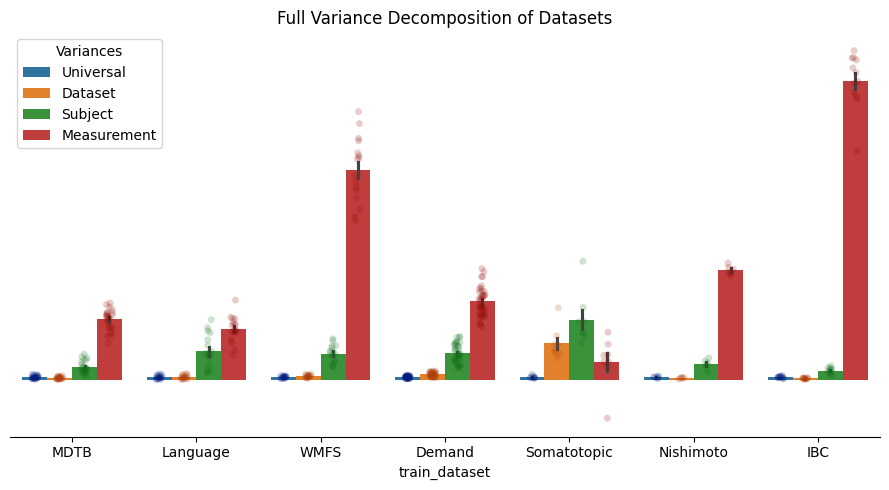

In [8]:
vars = ['v_u', 'v_d', 'v_s', 'v_m']
decom_df = full_var_decom_df.copy()
decom_df['v_m'] /= 2
decom_df[vars] = decom_df[vars].mul(decom_df['sc']**2, axis=0)
decom_df[vars] = decom_df.groupby('train_dataset')[vars].transform(lambda x: x / decom_df.loc[x.index, 'sc'].pow(2).mean())
df_decom_melt = decom_df.melt(id_vars=['train_dataset'], value_vars=vars, var_name='Variances', value_name='value')

plt.figure(figsize=(9, 5))
ax = sns.barplot(df_decom_melt, x='train_dataset', y='value', hue='Variances', errorbar='se')
sns.stripplot(df_decom_melt, x='train_dataset', y='value', hue='Variances', dodge=True, palette='dark', alpha=0.2, marker='o')

handles, labels = plt.gca().get_legend_handles_labels()
ax.legend(handles=handles, labels=['Universal', 'Dataset', 'Subject', 'Measurement'], title='Variances')
ax.set_yticks([])
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Full Variance Decomposition of Datasets')
plt.tight_layout()

### Normalize to total variance

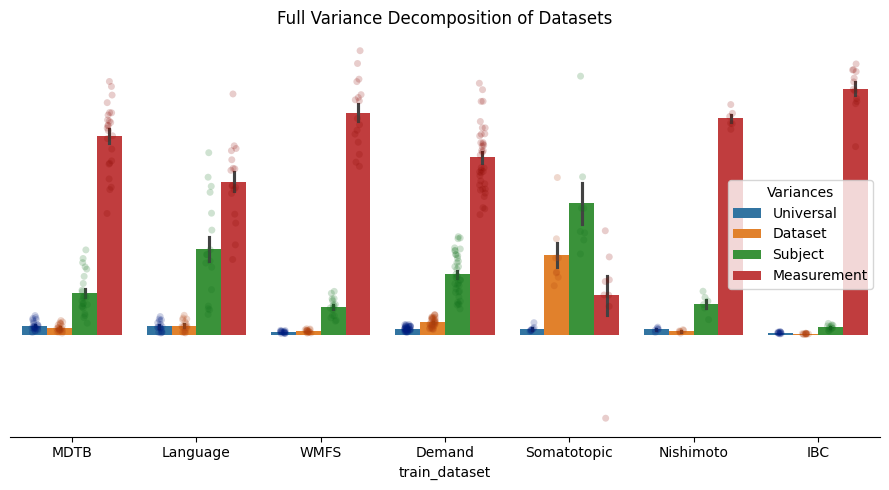

In [9]:
vars = ['v_u', 'v_d', 'v_s', 'v_m']
decom_df = full_var_decom_df.copy()
decom_df['v_m'] /= 2
decom_df[vars] = decom_df[vars].mul(decom_df['sc']**2, axis=0)
averages = decom_df.groupby('train_dataset')[vars].mean().sum(axis=1)
decom_df[vars] = decom_df.apply(lambda row: row[vars] / averages[row['train_dataset']], axis=1)
df_decom_melt = decom_df.melt(id_vars=['train_dataset'], value_vars=vars, var_name='Variances', value_name='value')

plt.figure(figsize=(9, 5))
ax = sns.barplot(df_decom_melt, x='train_dataset', y='value', hue='Variances', errorbar='se')
sns.stripplot(df_decom_melt, x='train_dataset', y='value', hue='Variances', dodge=True, palette='dark', alpha=0.2, marker='o')

handles, labels = plt.gca().get_legend_handles_labels()
ax.legend(handles=handles, labels=['Universal', 'Dataset', 'Subject', 'Measurement'], title='Variances')
ax.set_yticks([])
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Full Variance Decomposition of Datasets')
plt.tight_layout()

### Comparing new variance decomposition with old one

In [53]:
old_var_decom_df = pd.read_csv('/home/UWO/ashahb7/Github/bayes_temp/decom_var_df.tsv', sep='\t')
old_var_decom_df = old_var_decom_df[old_var_decom_df[['train_dataset', 'logalpha']].apply(tuple, axis=1).isin(zip(dataset_list, logalpha_list))]
old_var_decom_df['coef_var_m'] /= 2

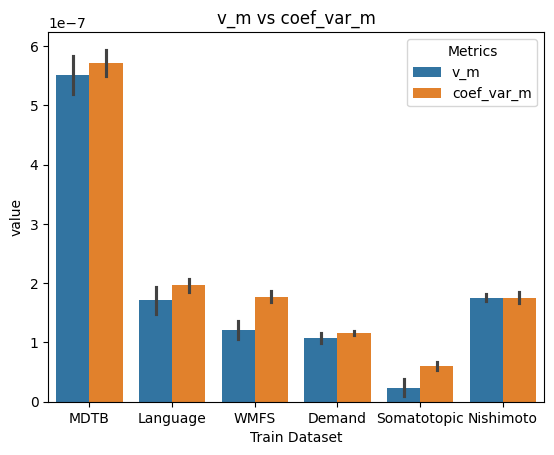

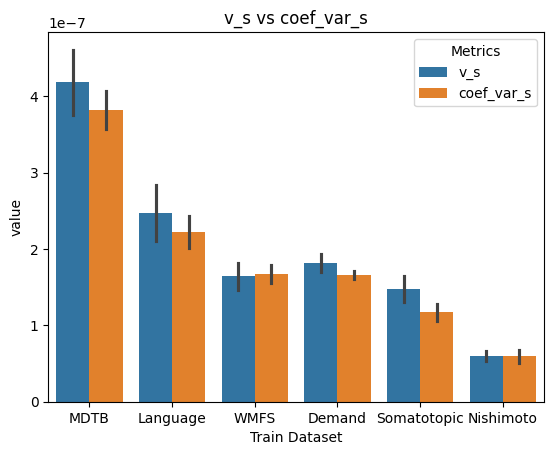

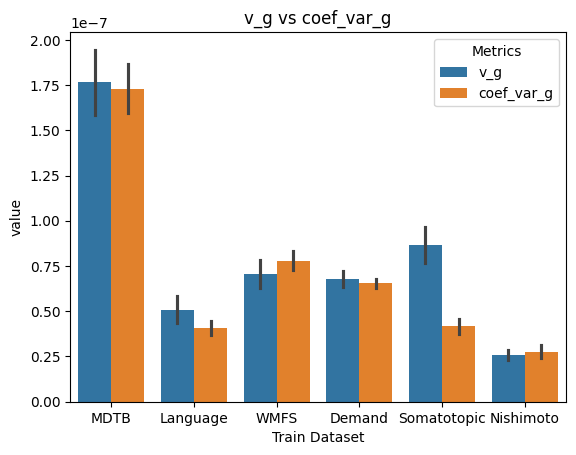

In [54]:
decom_df = full_var_decom_df.copy()
decom_df['v_m'] /= 2
decom_df[vars] = decom_df[vars].mul(decom_df['sc']**2, axis=0)
df_merge = pd.merge(decom_df, old_var_decom_df, on=['train_dataset', 'subj_id'])
df_merge['v_g'] = df_merge['v_u'] + df_merge['v_d']

# Plot for v_m vs coef_var_m
df_melt = df_merge.melt(id_vars=['train_dataset'], value_vars=['v_m', 'coef_var_m'], var_name='Metrics', value_name='value')
ax = sns.barplot(df_melt, x='train_dataset', y='value', hue='Metrics', errorbar='se')
ax.set_title('v_m vs coef_var_m')
ax.set_xlabel('Train Dataset')
plt.show()

# Plot for v_s vs coef_var_s
df_melt = df_merge.melt(id_vars=['train_dataset'], value_vars=['v_s', 'coef_var_s'], var_name='Metrics', value_name='value')
ax = sns.barplot(df_melt, x='train_dataset', y='value', hue='Metrics', errorbar='se')
ax.set_title('v_s vs coef_var_s')
ax.set_xlabel('Train Dataset')
plt.show()

# Plot for v_g vs coef_var_g
df_melt = df_merge.melt(id_vars=['train_dataset'], value_vars=['v_g', 'coef_var_g'], var_name='Metrics', value_name='value')
ax = sns.barplot(df_melt, x='train_dataset', y='value', hue='Metrics', errorbar='se')
ax.set_title('v_g vs coef_var_g')
ax.set_xlabel('Train Dataset')
plt.show()

### Comparing old single-W estimation with new single-W estimation

In [55]:
L2reg_df = pd.read_csv('/home/UWO/ashahb7/Github/bayes_temp/L2reg_df.tsv', sep='\t')
L2reg_df['coef_var'] /= 1876
L2reg2_df = pd.read_csv('/home/UWO/ashahb7/Github/bayes_temp/L2reg2_df.tsv', sep='\t')
L2reg2_df['coef_var'] /= 1876

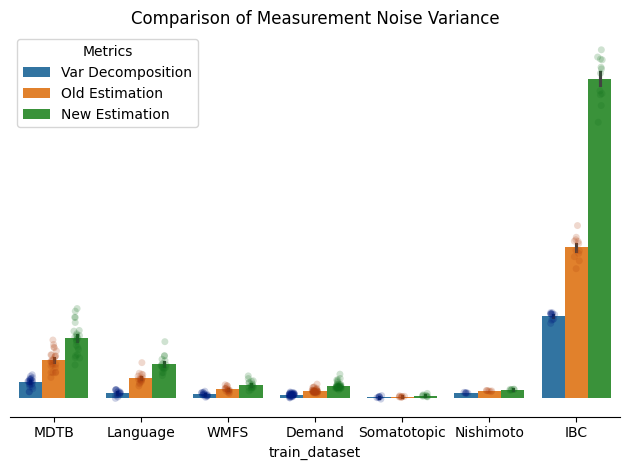

In [56]:
decom_df = full_var_decom_df.copy()
decom_df['v_m'] /= 2
decom_df['coef_var'] = decom_df['v_m'].mul(decom_df['sc']**2, axis=0)

df_merge = pd.merge(decom_df[['train_dataset', 'subj_id', 'coef_var']],
                    L2reg_df[['train_dataset', 'subj_id', 'coef_var']],
                    on=['train_dataset', 'subj_id'], suffixes=('_x', '_y'))
df_merge = pd.merge(df_merge,
                    L2reg2_df[['train_dataset', 'subj_id', 'coef_var']],
                    on=['train_dataset', 'subj_id'])
df_merge.rename(columns={'coef_var': 'coef_var_z'}, inplace=True)
df_melt = df_merge.melt(id_vars=['train_dataset'], value_vars=['coef_var_x', 'coef_var_y', 'coef_var_z'], var_name='Metrics', value_name='value')

ax = sns.barplot(df_melt, x='train_dataset', y='value', hue='Metrics', errorbar='se')
sns.stripplot(df_melt, x='train_dataset', y='value', hue='Metrics', dodge=True, palette='dark', alpha=0.2, marker='o')

handles, labels = plt.gca().get_legend_handles_labels()
ax.legend(handles=handles, labels=['Var Decomposition', 'Old Estimation', 'New Estimation'], title='Metrics')
ax.set_yticks([])
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Comparison of Measurement Noise Variance')
plt.tight_layout()